In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
import numpy as np, os
from scripts.core import *
from fastai.learner import Learner
import fastai
from torch.utils.data import Dataset
from scripts.models import *
from scripts.learners import modelLearner, ParallelLearner
from scripts.loss import weightedMSE
from functools import partial
import matplotlib.pyplot as plt

In [3]:
class Vid100Datasat(Dataset):
    def __init__(self, train=True, trim_start=50, trim_end=50):
        super().__init__()
        import random
        self.train=train
        self.trim_start,self.trim_end = trim_start,trim_end
        PTH = '/home/sufiyan/Common_data/mtp2/makeDataset/Sub Video/data/Mercedes_224_224_Manual_annonate_8sec_LSTM_short_005_'
        PTH_L=os.path.join(PTH,"LEFT")
        PTH_R=os.path.join(PTH,"RIGHT")
        PTH_C=os.path.join(PTH,"CLEAR")
        left_vids =[os.path.join(d,f) for d,_,fs in os.walk(PTH_L) for f in fs if f.split(".")[-1]=='npy']
        right_vids=[os.path.join(d,f) for d,_,fs in os.walk(PTH_R) for f in fs if f.split(".")[-1]=='npy']
        clear_vids=[os.path.join(d,f) for d,_,fs in os.walk(PTH_C) for f in fs if f.split(".")[-1]=='npy']
        self.fileNames=left_vids+right_vids
        self.fileNames=[filename for filename in self.fileNames if self.get_label(filename)[100]!="CLEAR"]
        np.random.shuffle(self.fileNames)
     
    @staticmethod
    def stoi(label):
        stoi={"CLEAR":0, "LEFT":1, "RIGHT":2}
        return stoi[label]
    
    def __getitem__(self,i):
        X=np.load(self.fileNames[i])[self.trim_start:-self.trim_end]
        y=self.get_label(self.fileNames[i])[self.trim_start:-self.trim_end]
        y=np.asarray([self.stoi(label) for label in y])
        X=np.expand_dims(X,1)
        X=np.concatenate((X,X,X), axis=1)
        return (torch.from_numpy(X), y)
    def __len__(self): return len(self.fileNames)
    
    def get_label(self, filename):
#         filename=self.fileNames[i]
        if self.train:
              return np.load(filename.replace('/data/','/label/'))
        else: return np.load(filename.replace('/data/','/val_label/'))

In [4]:
trainLoader=torch.utils.data.DataLoader(Vid100Datasat(train=True) ,batch_size=1, shuffle=True)
validLoader=torch.utils.data.DataLoader(Vid100Datasat(train=False),batch_size=1, shuffle=True)

In [5]:
learner=ParallelLearner([modelLearner(C3D_resnet_ConvLSTM2D(3, 3), loss_fn=partial(weightedMSE, [0,1,1]), optim=torch.optim.SGD, modelName="MSE_22Oct", lr=0.01, is_depth=True)], trainLoader=trainLoader, validLoader=validLoader, printEvery=100)

In [6]:
learner.train(epochs=20)

Avg Loss: 0.09755114355886524: 100%|██████████| 132/132 [01:34<00:00,  1.39it/s]


In [7]:
learner.lr=0.001
learner.train(10)

Avg Loss: 0.0957657616077499: 100%|██████████| 132/132 [01:34<00:00,  1.40it/s] 


In [18]:
l=learner.learners[0]

#### Plotting Confussion Matrix

In [21]:
print(l.train_confusion_matrix_list[-1])
print()
print(l.valid_confusion_matrix_list[-1])

[[  37 5478 2617]
 [   0 1674  860]
 [   0 1782  752]]

[[   0 6306 1826]
 [   0 2534    0]
 [   0 1304 1230]]


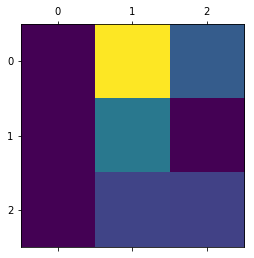

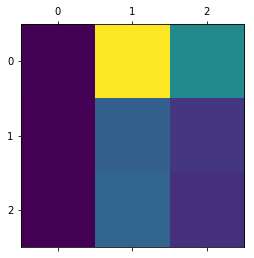

In [22]:
plt.matshow(l.valid_confusion_matrix_list[-1])
plt.matshow(l.train_confusion_matrix_list[-1])

#### Losses

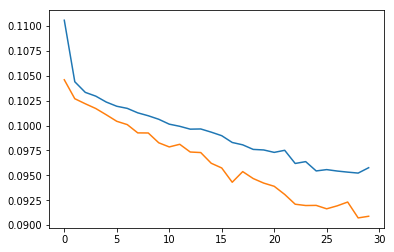

In [16]:
plt.plot(l.train_loss_list)
plt.plot(l.test_loss_list)

In [62]:
def compare_output():
    for x,y in validLoader:
        y=y.squeeze_()
        x = x.float().to(device)
        y = y.float().to(device)
        l.Train=False #setting to eval mode
        l.model.eval()
        y_pred=l.model(x)
        y_pred=y_pred.squeeze_()
        print(y.shape)
#         y_pred=F.softmax(y_pred)
        print(y_pred)
        print()
        print(y)
        yield None
    

In [63]:
print_compare_output=iter(compare_output())

#### The probabilities of 1 and 2 are almost same

In [64]:
next(print_compare_output)

torch.Size([100])
tensor([[-0.0066,  0.1964,  0.1887],
        [-0.0066,  0.1964,  0.1887],
        [-0.0066,  0.1964,  0.1887],
        [-0.0066,  0.1964,  0.1887],
        [-0.0097,  0.1643,  0.2203],
        [-0.0111,  0.1592,  0.2434],
        [-0.0066,  0.1964,  0.1887],
        [-0.0165,  0.1608,  0.2846],
        [-0.0066,  0.1964,  0.1887],
        [-0.0066,  0.1964,  0.1887],
        [-0.0066,  0.1964,  0.1887],
        [-0.0066,  0.1964,  0.1887],
        [-0.0066,  0.1964,  0.1887],
        [-0.0292,  0.1815,  0.3479],
        [-0.0289,  0.1830,  0.3568],
        [-0.0066,  0.1964,  0.1887],
        [-0.0262,  0.1899,  0.3697],
        [-0.0066,  0.1964,  0.1887],
        [-0.0066,  0.1964,  0.1887],
        [-0.0253,  0.1992,  0.3668],
        [-0.0261,  0.2023,  0.3697],
        [-0.0066,  0.1964,  0.1887],
        [-0.0254,  0.1999,  0.3679],
        [-0.0228,  0.1973,  0.3683],
        [-0.0066,  0.1964,  0.1887],
        [-0.0066,  0.1964,  0.1887],
        [-0.0204,  0